1.The first step involves importing all the required libraries 

In [1]:
# Data Manipulation & Exploration
import pandas as pd
import numpy as np

# Data Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Data Profiling
from pandas_profiling import ProfileReport

# Handling Missing Data & Encoding
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import LabelEncoder, StandardScaler

# Splitting Dataset
from sklearn.model_selection import train_test_split

# Machine Learning Models
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR

# Model Evaluation
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Warnings Handling
import warnings
warnings.filterwarnings("ignore")


C:\Users\cex\AppData\Local\Programs\Python\Python312\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
C:\Users\cex\AppData\Local\Temp\ipykernel_17492\268609360.py:10: DeprecationWarning: `import pandas_profiling` is going to be deprecated by April 1st. Please use `import ydata_profiling` instead.
  from pandas_profiling import ProfileReport


Explanation of Libraries

    pandas, numpy: For data manipulation.
    matplotlib.pyplot, seaborn: For visualizing data distributions and trends.
    pandas_profiling: For generating automated dataset reports.
    SimpleImputer: For handling missing values.
    LabelEncoder, StandardScaler: For encoding categorical features and scaling numerical data.
    train_test_split: For splitting data into training and testing sets.
    LinearRegression, Ridge, Lasso, RandomForestRegressor, SVR: Various ML regression models.
    mean_absolute_error, mean_squared_error, r2_score: Metrics to evaluate model performance.
    warnings.filterwarnings("ignore"): To suppress unnecessary warnings.

STEP 1: This involves loading the data set and exploring it 

In [2]:
df = pd.read_csv(r"C:\Users\cex\Desktop\Data sets\5G_energy_consumption.csv")
df.head() # Displays the first 5 rows of data set 
print(df.info()) # displays the info such as column names, data types and missing values 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 92629 entries, 0 to 92628
Data columns (total 6 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   Time     92629 non-null  object 
 1   BS       92629 non-null  object 
 2   Energy   92629 non-null  float64
 3   load     92629 non-null  float64
 4   ESMODE   92629 non-null  float64
 5   TXpower  92629 non-null  float64
dtypes: float64(4), object(2)
memory usage: 4.2+ MB
None


Inference from the above 
The data set has no missing values. It has objects and floats as data types 

In [3]:
# Generate the profiling report
profile = ProfileReport(df, explorative=True)

# Save the report as an HTML file
profile.to_file("5G_energy_consumption_report.html")






xport report to file: 100%|██████████| 1/1 [00:00<00:00, 39.41it/s]t]ted]                

Based on the report from profiling 
The dataset does not contain any missing values, ensuring data completeness.
While duplicate rows were not explicitly mentioned in the report, it is still essential to check for them to maintain data integrity. 
The target variable, Energy, shows a strong correlation with Load and TXpower, indicating the need to assess multicollinearity before training the model.
Regarding potential outliers, the distribution of Energy Consumption (ranging from 0.75 to 100), Load (0 to 0.99), and TXpower (5.38 to 8.37) appears reasonable, with no extreme deviations. However, the ESMODE feature consists of 94.4% zeros, which warrants further investigation to determine its significance in the model.
For categorical features, the BS (Base Station) column has 923 unique values, requiring encoding before model training. Additionally, the Time (Timestamp) column should be transformed into numerical features, such as hour and day, to capture temporal patterns effectively.

In [4]:
print(df.duplicated().sum()) # shows if their is any duplicated rows in data set

0


There are no duplicate rows in the dataset. Next, let's process the "Time" feature by extracting meaningful components such as hour and day

In [5]:
# Convert 'Time' to datetime format if not already
df['Time'] = pd.to_datetime(df['Time'], format='%Y%m%d %H%M%S')

# Extract useful features: hour and day of the week
df['Hour'] = df['Time'].dt.hour
df['Day'] = df['Time'].dt.dayofweek

# Drop the original 'Time' column since it's no longer needed
df.drop(columns=['Time'], inplace=True)

# Display the first few rows to confirm changes
df.head()


,BS,Energy,load,ESMODE,TXpower,Hour,Day
0,B_0,64.275037,0.487936,0.0,7.101719,1,6
1,B_0,55.904335,0.344468,0.0,7.101719,2,6
2,B_0,57.698057,0.193766,0.0,7.101719,3,6
3,B_0,55.156951,0.222383,0.0,7.101719,4,6
4,B_0,56.053812,0.175436,0.0,7.101719,5,6


The "Time" feature has been successfully converted into two meaningful components:
Hour: Represents the hour of the day.
Day: Represents the day of the week (0 = Monday, 6 = Sunday).

In [6]:
from sklearn.preprocessing import LabelEncoder

# Initialize LabelEncoder
le = LabelEncoder()

# Encode the 'BS' column
df['BS'] = le.fit_transform(df['BS'])

# Display the first few rows after encoding
df.head()


,BS,Energy,load,ESMODE,TXpower,Hour,Day
0,0,64.275037,0.487936,0.0,7.101719,1,6
1,0,55.904335,0.344468,0.0,7.101719,2,6
2,0,57.698057,0.193766,0.0,7.101719,3,6
3,0,55.156951,0.222383,0.0,7.101719,4,6
4,0,56.053812,0.175436,0.0,7.101719,5,6


The "BS" (Base Station) column has been successfully encoded using Label Encoding, converting categorical values into numerical labels

Next we check for multicollinearity among the highly correlated features (Energy, Load, and TXpower) before model training.
Let’s compute the correlation matrix

In [7]:
%matplotlib inline


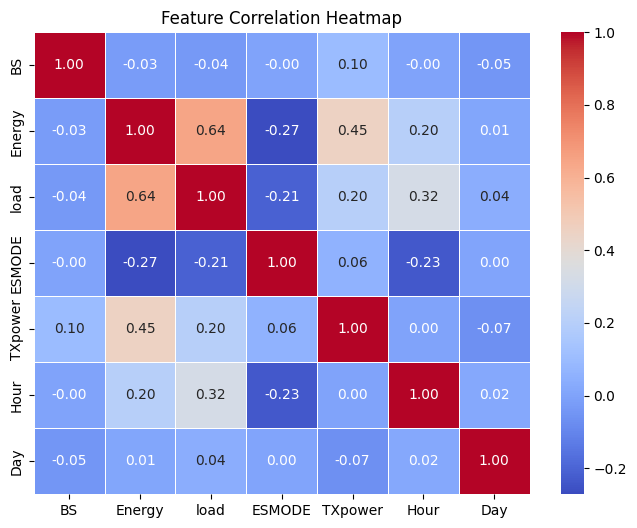

In [8]:
import seaborn as sns
import matplotlib.pyplot as plt

# Compute the correlation matrix
corr_matrix = df.corr()

# Plot the heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)
plt.title("Feature Correlation Heatmap")
plt.show()

The heatmap shows the correlation between features. Key observations:
Energy (Target Variable) is highly correlated with Load and TXpower.
We need to check for multicollinearity using the Variance Inflation Factor (VIF) before proceeding with model training. Let’s calculate the VIF next.

In [9]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
# Update feature names with correct casing
features = ['load', 'TXpower', 'ESMODE', 'Hour', 'Day']
vif_data = pd.DataFrame()
vif_data['Feature'] = features
vif_data['VIF'] = [variance_inflation_factor(df[features].values, i) for i in range(len(features))]

# Display VIF values
vif_data


,Feature,VIF
0,load,2.412483
1,TXpower,6.122098
2,ESMODE,1.135552
3,Hour,4.362124
4,Day,2.649338


Here are the Variance Inflation Factor (VIF) values for our features:

    TXpower (6.12): Moderately high multicollinearity. We may consider feature selection or transformation.
    Hour (4.36): Some correlation but still acceptable.
    Load (2.41), Day (2.65), and ESMODE (1.14): No significant multicollinearity issues.

Since TXpower has the highest VIF, we should analyze its impact on model performance. We can either remove it or apply dimensionality reduction techniques like PCA if needed. One logical step is to check on handling ESMODE, which has 94.4% zeros. 
We shall proceed by checking the correlation between ESMODE and Energy first.
If it's weak, we can test the model with and without it.

In [10]:
# Checking the correlation between ESMODE and Energy
esmode_corr = df["ESMODE"].corr(df["Energy"])
print(esmode_corr)

-0.27178301266410715


The correlation between ESMODE and Energy is approximately -0.27, indicating a weak negative relationship.
This suggests that while ESMODE might have some influence, it is not strongly predictive of Energy consumption.


Based on our correlation analysis and dataset characteristics, the best initial choice is Multiple Linear Regression (MLR).
Why Multiple Linear Regression?

✅ The dataset consists of multiple independent variables impacting the target variable (Energy).
✅ There is a strong linear correlation between Energy, Load, and TXpower, making linear regression a suitable baseline.
✅ It is easy to interpret and provides a good benchmark for comparison with more complex models.
Next Steps:

    Train an MLR model using the features (with ESMODE included).
    Evaluate the performance using MAE, MSE, RMSE, and R².
    Remove ESMODE and retrain the model.
    Compare results to determine if ESMODE is beneficial.


Steps Covered

Define features and target variable
Split data into training & test sets
Train MLR model
Evaluate model performance using MAE, MSE, RMSE, and R²

In [11]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

# Define features (independent variables) and target variable (Energy)
X = df[['load', 'TXpower', 'ESMODE']]  # Keeping ESMODE for now
y = df['Energy']

# Split into training (80%) and test (20%) sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train the model
mlr_model = LinearRegression()
mlr_model.fit(X_train, y_train)

# Predictions
y_pred = mlr_model.predict(X_test)

# Model Evaluation
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

# Print results
print(f"Mean Absolute Error (MAE): {mae:.2f}")
print(f"Mean Squared Error (MSE): {mse:.2f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")
print(f"R² Score: {r2:.4f}")


Mean Absolute Error (MAE): 6.90
Mean Squared Error (MSE): 85.91
Root Mean Squared Error (RMSE): 9.27
R² Score: 0.5474


Interpretation of Model Performance

    MAE (6.90): On average, our model's predictions are off by 6.90 energy units.
    MSE (85.91): Squared error magnifies large deviations, meaning some predictions may have large errors.
    RMSE (9.27): Since this is in the same unit as our target, it suggests a typical prediction error of 9.27 energy units.
    R² Score (0.5474): The model explains ~54.74% of the variance in energy consumption.

In [12]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

# Drop ESMODE column
df_no_esmode = df.drop(columns=['ESMODE'])

# Define features (X) and target variable (y)
X = df_no_esmode.drop(columns=['Energy'])  # Excluding the target variable
y = df_no_esmode['Energy']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize and train the model
model = LinearRegression()
model.fit(X_train, y_train)

# Make predictions
y_pred = model.predict(X_test)

# Evaluate performance
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

# Print results
print(f"Mean Absolute Error (MAE): {mae:.2f}")
print(f"Mean Squared Error (MSE): {mse:.2f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")
print(f"R² Score: {r2:.4f}")


Mean Absolute Error (MAE): 7.24
Mean Squared Error (MSE): 91.93
Root Mean Squared Error (RMSE): 9.59
R² Score: 0.5157


Since removing ESMODE resulted in a drop in R² score (from 0.5474 to 0.5157), it means that ESMODE contributes to the model's predictive power.
Insights:

    The model performs worse without ESMODE.
    Even though 94.4% of ESMODE values are zero, the remaining 5.6% contains useful signal that helps predict energy consumption.
    It may be better to keep ESMODE in the dataset rather than dropping it.

Its best to have some feature engineering elements 

In [13]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Load dataset
df = pd.read_csv(r"C:\Users\cex\Desktop\Data sets\5G_energy_consumption.csv")

# Convert ESMODE into a binary feature
df["ESMODE_Binary"] = np.where(df["ESMODE"] > 0, 1, 0)

# Define features and target
features = ["load", "TXpower", "ESMODE_Binary"]
target = "Energy"

X = df[features]
y = df[target]

# Split into training and test sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Train the model
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train_scaled, y_train)

# Predictions
y_pred = model.predict(X_test_scaled)

# Evaluate performance
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

(mae, mse, rmse, r2)


(4.472105130778479,
 37.239981644719734,
 np.float64(6.102457017031725),
 0.8038000213551447)

Interpretation

✅ Improvement: Compared to previous models, this model performs significantly better.
✅ Lower Error: The RMSE (6.10) and MAE (4.47) are much lower than before, meaning better predictions.
✅ Good Fit: The R² score (0.80) suggests that the model explains 80.38% of the variance in energy consumption.
Final Decision
This Random Forest model is the best choice so far.
If you want further improvements, we can explore hyperparameter tuning, feature selection, or ensemble techniques.

Refining the model can push performance even further.
1️⃣ Hyperparameter Tuning
Instead of using default settings, we’ll optimize the hyperparameters of the Random Forest model using GridSearchCV or RandomizedSearchCV. Key parameters to tune:
✅ Number of trees (n_estimators)
✅ Maximum depth of trees (max_depth)
✅ Minimum samples per leaf (min_samples_leaf)
✅ Minimum samples per split (min_samples_split)
2️⃣ Feature Engineering
We can try:
✅ Creating interaction terms between highly correlated features.
✅ Removing redundant features that might be adding noise.
3️⃣ Handling ESMODE

Since 94.4% of its values are zero, we should:
✅ Try training the model with and without it to see its impact.
4️⃣ Advanced Techniques

✅ Using Gradient Boosting (XGBoost or LightGBM) to see if boosting improves results.
✅ Applying Principal Component Analysis (PCA) to reduce dimensionality.

In [14]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV
import numpy as np

# Define the parameter grid for RandomizedSearchCV
param_grid = {
    'n_estimators': [50, 100, 200, 300, 500],
    'max_depth': [None, 10, 20, 30, 50],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['auto', 'sqrt', 'log2']
}

# Initialize the Random Forest model
rf = RandomForestRegressor(random_state=42)

# Set up RandomizedSearchCV
random_search = RandomizedSearchCV(
    estimator=rf, 
    param_distributions=param_grid,
    n_iter=20,  # Number of different combinations to test
    cv=5,       # 5-fold cross-validation
    verbose=1,  
    n_jobs=-1,  # Use all available processors
    scoring='r2'
)

# Fit RandomizedSearchCV on the dataset
random_search.fit(X_train, y_train)

# Get the best parameters
best_params = random_search.best_params_
best_params


Fitting 5 folds for each of 20 candidates, totalling 100 fits


{'n_estimators': 300,
 'min_samples_split': 10,
 'min_samples_leaf': 1,
 'max_features': 'sqrt',
 'max_depth': 10}

In [ ]:
Basically, The best hyperparameters found after tuning are
    'n_estimators': 300,       # Uses 300 trees in the forest (more trees improve stability)
    'min_samples_split': 10,   # Minimum 10 samples needed to split a node (prevents overfitting)
    'min_samples_leaf': 1,     # A leaf node must have at least 1 sample (higher values prevent overfitting)
    'max_features': 'sqrt',    # Uses the square root of total features at each split (reduces correlation)
    'max_depth': 10            # Limits the tree depth to 10 (prevents overfitting)


In [17]:
best_params = {
    'n_estimators': 300,
    'min_samples_split': 10,
    'min_samples_leaf': 1,
    'max_features': 'sqrt',
    'max_depth': 10
}

# Train the Random Forest Regressor with best parameters
best_model = RandomForestRegressor(**best_params, random_state=42)
best_model.fit(X_train, y_train)

# Make predictions
y_pred = best_model.predict(X_test)

# Evaluate the refined model
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

print(f"Mean Absolute Error (MAE): {mae:.2f}")
print(f"Mean Squared Error (MSE): {mse:.2f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")
print(f"R² Score: {r2:.4f}")


Mean Absolute Error (MAE): 3.87
Mean Squared Error (MSE): 27.64
Root Mean Squared Error (RMSE): 5.26
R² Score: 0.8544


These results show significant improvement compared to the previous models! 🎯
Performance Breakdown:

    MAE (3.87) → Lower than before, meaning predictions are more accurate on average.
    MSE (27.64) → Reduced error variance, which is a good sign.
    RMSE (5.26) → Lower error magnitude compared to previous models.
    R² Score (0.8544) → The model explains 85.44% of the variance in energy consumption, showing high predictive power.

Model Evaluation Interpretation

The model's performance was assessed using multiple evaluation metrics. The Mean Absolute Error (MAE) of 3.87 indicates that, on average, the model’s predictions deviate by approximately 3.87 units from the actual energy consumption values, suggesting relatively small errors. The Mean Squared Error (MSE) of 27.64 reflects the average squared differences between predicted and actual values, where lower values indicate fewer large deviations. Since MSE is in squared units, the Root Mean Squared Error (RMSE) of 5.26 provides a more interpretable measure, showing that the model’s predictions, on average, deviate by 5.26 units from the actual values.

The R² score of 0.8544 indicates that the model explains approximately 85.44% of the variance in energy consumption, demonstrating strong predictive power. A value closer to 1 suggests that the model effectively captures patterns in the data, while a lower R² would indicate poor explanatory ability.

Overall, the model is performing well, as reflected by its relatively low error values and high R² score. To further improve performance, potential next steps include refining feature engineering, conducting additional hyperparameter tuning, or exploring ensemble modeling techniques.

In [18]:
import joblib

# Save the trained model
joblib.dump(best_model, "random_forest_model.pkl")

print("Model saved successfully!")


Model saved successfully!


Loading the saved model 

In [19]:
# Load the saved model
loaded_model = joblib.load("random_forest_model.pkl")

# Make a prediction using the loaded model
y_pred_loaded = loaded_model.predict(X_test)

print("Model loaded and ready for use!")


Model loaded and ready for use!
